# Multiple Linear Regression: Student Performance

This notebook presents the building of a multiple linear regression model using the Student Performance synthetic dataset from Kaggle (see below). This project begins with exploratory data analysis, then selecting and normalizing the features, training the model using the SGDRegressor from sklearn and using an own implementation of Batch Gradiend Descent. Finally both models where evaluated. From EDA it was found that only two features were relevant to the target. However, with the purpuse of showing the difference between using relevant features (model 2) and using all the features (model 1), both subsets were used to train the models. Both implementations showed there were almost no difference in the score using both subsets. The differece in score for the two implementations were also negligable, with a value of 0.9864 for model 1.



Author: Alexander Burgos

Fecha: 2025-02-10


### Dataset

Data taken from Kaggle: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

**Description**: The Student Performance Dataset is a dataset designed to examine the factors influencing academic student performance. The dataset consists of 10,000 student records, with each record containing information about various predictors and a performance index. 

THIS DATASET WAS SYNTHETIC AND CREATED.

**Variables**:

| Features | Meaning |
| -- | -- |
| Hours Studied | The total number of hours spent studying by each student.
| Previous Scores | The scores obtained by students in previous tests.
| Extracurricular Activities | Whether the student participates in extracurricular activities (Yes or No).
| Sleep Hours | The average number of hours of sleep the student had per day.
| Sample Question Papers Practiced | The number of sample question papers the student practiced.

**Target Variable**:

**Performance Index**: A measure of the overall performance of each student. The performance index represents the student's academic performance and has been rounded to the nearest integer. The index ranges from 10 to 100, with higher values indicating better performance.


In [1]:
# import kaggle as kg
# kg.api.authenticate()

# Download data
# kg.api.dataset_download_files(dataset='nikhil7280/student-performance-multiple-linear-regression', unzip=True, path='data')

In [2]:
# Loading necessary libraries
import numpy as np # numerical computing
import pandas as pd # data handling
import matplotlib.pyplot as plt # figures
import seaborn as sns # data visualizations

In [3]:
# Load data
df = pd.read_csv('data/Student_Performance.csv')

# Exploratory Data Analysis

In [4]:
# Quick inspect
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


From quick inspect we observe there are 6 columns, 5 of them are the variables and the last column is the target. From the variables we see there are four columns with discrete numeric values, while "Extracurricular Activities" column is probably a binary categorical variable, according with the description. The target seems to be a float type, in concordance with the column description.

Let's see more detailed data information.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


- Each column was identified with appropriate Dtypes, as it was discussed above.
- It seems that pandas didn't indentified any non-null value in any column, so that's a good sign. However, we need to inspect further to check if there are non-sense values for each column that can be considered as errors, missings, or outliers. 

In [6]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


From the describe function we see there are no anomalies in each feature, meaning that there are not any weird value to be considered as null. Also, we can notice from **min** and **max** the difference in the range of values, particulary the *previous scores* feature ranges from 40 to 100, and all the other three features range from 1 to 10 approximately.

In [7]:
# Object type feature
df["Extracurricular Activities"].unique()

array(['Yes', 'No'], dtype=object)

As we suspect earlir about the object type column, there are only two possible values: yes and no.

## Univariate Statistics

Let's inspect further each variable.

### Distributions of Quantitative Variables

Identifying pattern and relevant insight from each feature.


In [8]:
# Subset with only discrete numerical variables and target
df_discrete = df.select_dtypes('int64')
col_discrete = df_discrete.columns

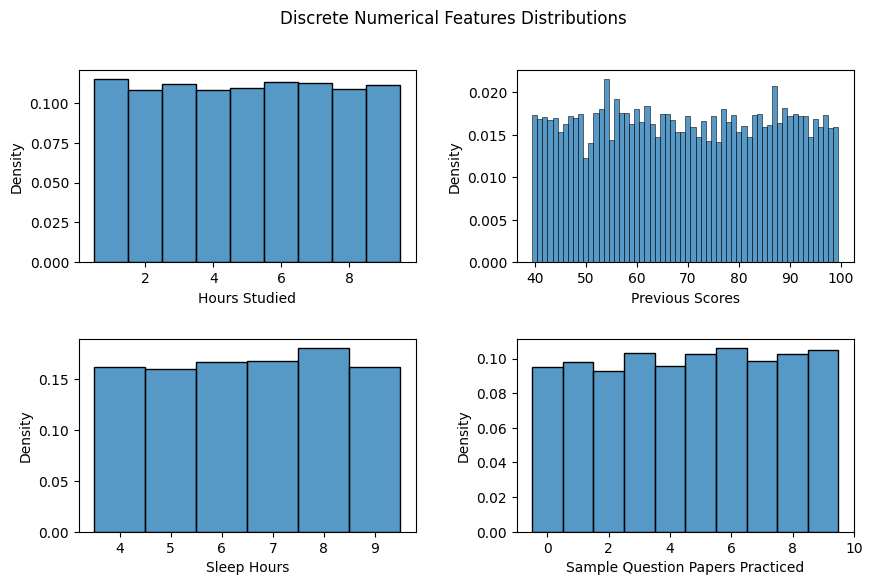

In [9]:
# Create subplots (1 rows, 4 columns)
fig, ax = plt.subplots(2,2, figsize=(10,6))

# Create histogram for each position 
# sns.histplot(df_discrete[col_discrete[0]], ax=ax[0][0], stat='density', bins=9, binwidth=0.5, binrange=(1,9.5))
sns.histplot(df_discrete[col_discrete[0]], ax=ax[0][0], stat='density', discrete=True)

sns.histplot(df_discrete[col_discrete[1]], ax=ax[0][1], stat='density', discrete=True)

sns.histplot(df_discrete[col_discrete[2]], ax=ax[1][0], stat='density', discrete=True)

sns.histplot(df_discrete[col_discrete[3]], ax=ax[1][1], stat='density', discrete=True)

fig.suptitle("Discrete Numerical Features Distributions")
fig.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

- All feature distributions shown above shows nearly uniform distributions, meaning that there are the same number of students for each variable value. That is, for example, for each number of hours studied (from 1 to 9) there is 12 percent of students that studies 1 hour, 12 percent 2 hours, and so on.
- For *hours studied* distribution se see a little peack at 1 hours, so there are a few students more studying 1 hour.
- For *sleep hours* distribution we see a little peak at 8 hours, so there are more studends that sleep that number of hours than sleeping more or less hours.
- For *sample question papers practiced* we see a very small tendency for students practicing more papers.
- Finally, the "previous scores" distribution has two peaks around 55 and 88, so there are more students with those previous scores that with other scores. But still it can be seen that all students splits having different previous scores. A minimun is observed at 50 score.

### Frecuency of Categorical Variables

In [10]:
df[df.select_dtypes('object').columns].value_counts(normalize=True)

Extracurricular Activities
No                            0.5052
Yes                           0.4948
Name: proportion, dtype: float64

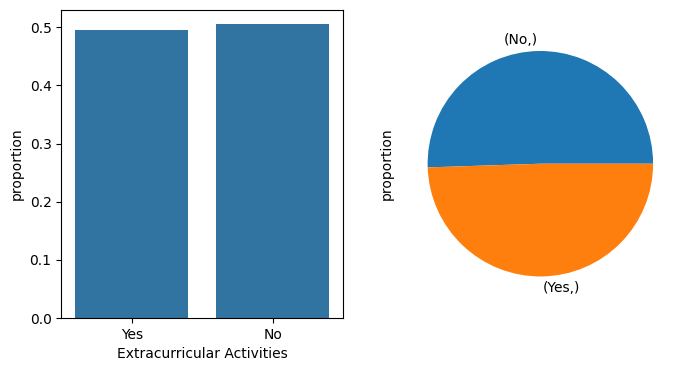

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.countplot(x=df.select_dtypes('object').columns[0], data=df, stat='proportion', ax=ax[0])

df[df.select_dtypes('object').columns].value_counts(normalize=True).plot.pie(ax=ax[1])

plt.show()

It is clear that for *extracurricular activities* variable nearly the same number of students are and are not takings those activities.

## Bivariate Statistics

Let's inspect know the relationships between pair of variables.

### Assesing Relationships between Variables

In [12]:
df_discrete = df.select_dtypes("int64")
col_discrete = df_discrete.columns

#### **Quantitative vs Quantitative**

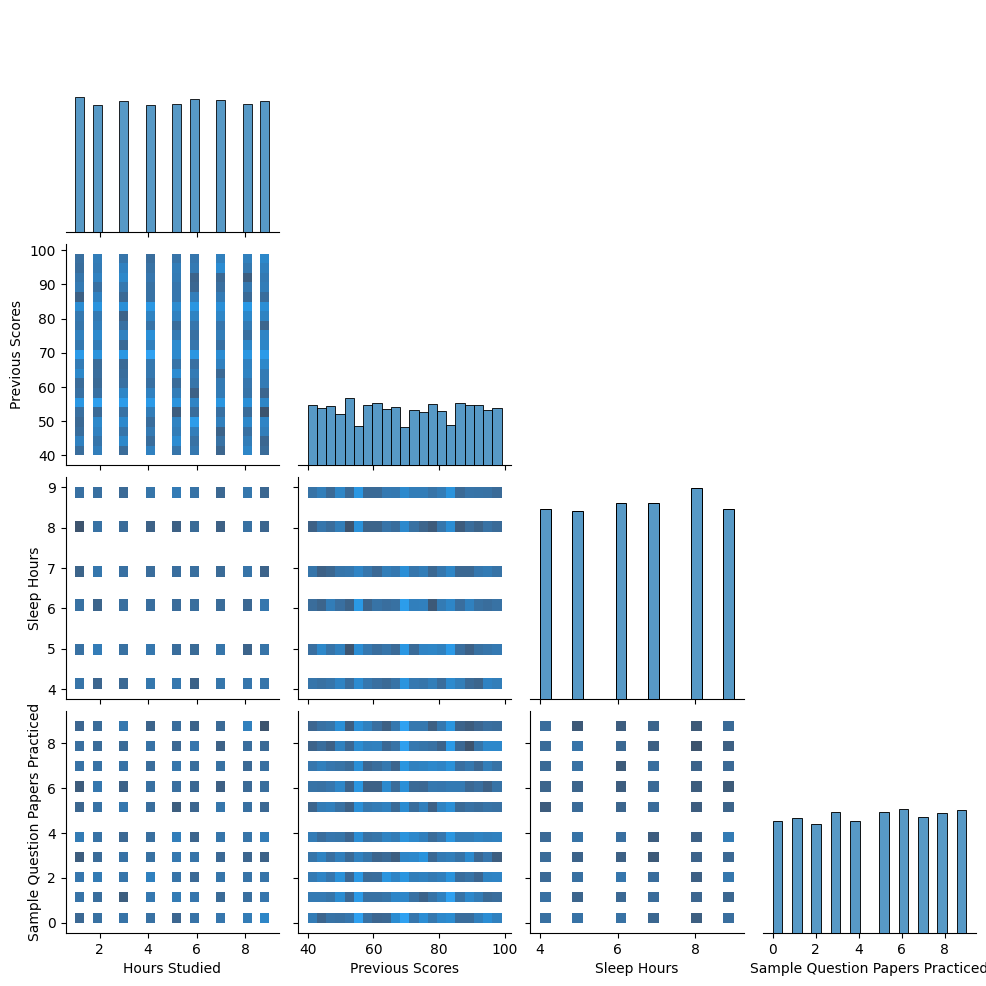

In [13]:
sns.pairplot(df_discrete, corner=True, kind='hist')

We see above a matrix of pair-wise scatter plots, in the diagonal it is shown the distribution of the variable.
- In all of the pair-wiser scatter plot we can't see any clear pattern between variables, so each pair is almost independet of each other and have its own information.

#### **Categorical vs Quantitative**

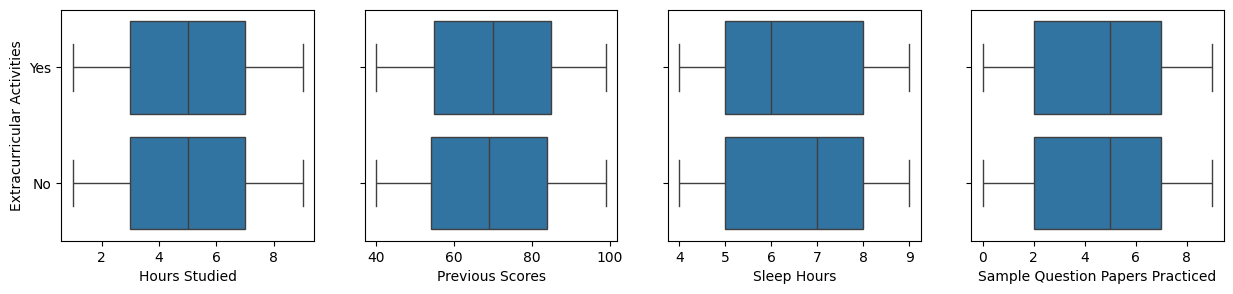

In [14]:
fig, ax = plt.subplots(1, len(col_discrete), figsize=(15,3), sharey=True)

for i in range(len(col_discrete)):
    sns.boxplot(x=df_discrete.iloc[:,i], y=df['Extracurricular Activities'], ax=ax[i])

The side by side boxplots for each quantitative feature respect to the unique categorical feature is described below:
- The first, second, and fourth figures shows no relation between *Extracurricular Activities* and the quantitative features: the distribution of hours studied of students who take extracurricular activities is the same as the students who don't take those activities. The same is true for *previous scores* and *sample question papers practices*.
- For *sleep hours* feature there is a similar behaviour, 50% of data is contained between 5 and 8 hours, but the median is different: 50% of students who take extracurricular activities sleeps 6 hours or less, and those students who don't take the activities sleeps 7 hours or less.
- One more thing to notice is that there aren't any outliers for all features, so any value is too far from most of values. 

### Assesing Relationships between Variables and Target

#### **Quantitative vs Quantitative**

[]

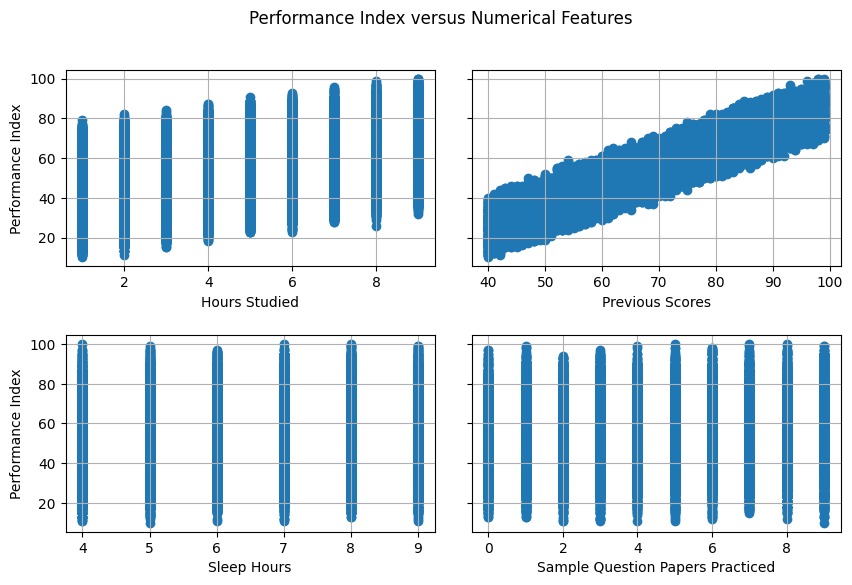

In [15]:
fig, ax = plt.subplots(2,2, figsize=(10,6), sharey=True)

counter = 0
for i in range(2):
    for j in range(2):
        
        ax[i][j].scatter(df_discrete[col_discrete[counter]], df.iloc[:,-1])
        ax[i][j].set_xlabel(col_discrete[counter])
        if j == 0:
            ax[i][j].set_ylabel(df.iloc[:,-1].name)
        ax[i][j].grid()
        counter += 1

fig.suptitle("Performance Index versus Numerical Features")
fig.subplots_adjust(wspace=0.1, hspace=0.35)
plt.plot()

We have four scatter plots that are described below:
- In the upper part of the figure we can see *hours studied* and *previous scores* features having a positive linear dependence respect to *perfomance index*. That is, students who studies more hours or scores higher in previous evaluations has a better performance. It is more clear with *previous scores* feature.
- For *sleep hours* and *sample questions papers practiced* features we don't see a clear relationship respect to *perfomance index*. Also, it looks like there is no relation at all between those features and the target.
- As well as it was said describing the dataset above, we can also see the different scale of the features: while for the *previous scores* feature we observe values from 40 to 100, the other features shows values between 1-10.

Let's find the Pearson correlation.

In [16]:
from scipy.stats import pearsonr

print("Person Correlation Value Between Discrete Features and Target")
for num_col in col_discrete:
    corr, p = pearsonr(df[num_col], df['Performance Index'])

    print(f"Feature: {num_col}\n    Corr:{corr:.4f}")


Person Correlation Value Between Discrete Features and Target
Feature: Hours Studied
    Corr:0.3737
Feature: Previous Scores
    Corr:0.9152
Feature: Sleep Hours
    Corr:0.0481
Feature: Sample Question Papers Practiced
    Corr:0.0433


As it was suggest from the graphs, only *hours studied* and *previous scores* features have a relationship with *performance index*:
- *hours studied* has a correlation of 0.37 indicating a weak relationship.
- *previous scores* has a correlation of 0.92 indicanting a strong relationship.

#### **Categorical vs Quantitative**

In [17]:
df_categorical = df.select_dtypes("object")
df_categorical[df.iloc[:,-1].name] = df.iloc[:,-1]
df_categorical.groupby(df_categorical.columns[0]).mean()

,Performance Index
Extracurricular Activities,
No,54.758511
Yes,55.700889


<Axes: xlabel='Performance Index', ylabel='Extracurricular Activities'>

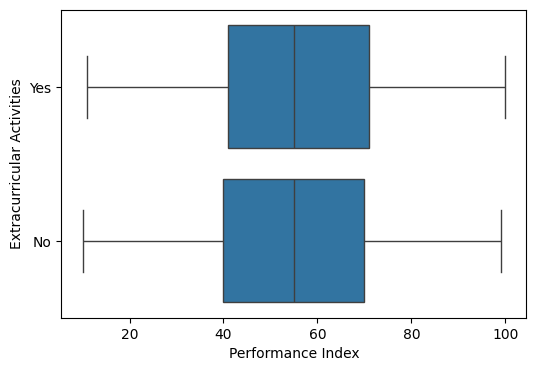

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x=df['Performance Index'], y=df['Extracurricular Activities'])


We observe there is almost no relationship *between extracurricular* activities and *performance index*. 

From EDA we found important insights:
- All features are in appropriate formats.
- The scale of the features values are different.
- There are not any missing values and outliers.
- All features have nearly a uniform distribution.
- There are some features in the dataset about the students that almost does not influence the student's performance index: *sleep hours*, *extracurricular activities*, and *sample question papers practice*.

From what we have found, we can begin using the datset for modeling, but need to take some considerations:
- We need to scale or normalize the features values so that the training converges better and faster.
- We can consider using only those features who have correlation with the target.

# Predictions: Linear Regression Algorithm

First, we are going to train a model with all features from the dataset. Then, we will only consider those who has some relation with the target *performance index* to train another model. Finally, we are going to assess the performance of both models. We expect that adding more features won't increase the model performance significantly. 

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from modules import linear_regression as lr

**Pre-Processing Data to the Train the Model**

In [20]:
columns = df.columns
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [21]:
# Converting object type feature to integer: yes = 1, no = 0
df_new = df.copy()
df_new['Extracurricular Activities'] = df_new['Extracurricular Activities'].apply(lambda value: 1 if value == 'Yes' else 0)

# Load as np
data = df_new.to_numpy()
data[0:5]

array([[ 7., 99.,  1.,  9.,  1., 91.],
       [ 4., 82.,  0.,  4.,  2., 65.],
       [ 8., 51.,  1.,  7.,  2., 45.],
       [ 5., 52.,  1.,  5.,  2., 36.],
       [ 7., 75.,  0.,  8.,  5., 66.]])

Scaling/Normalizing Data

Makes the algorithm runs better and faster.

In [22]:
# Scaling features: z-score scaling
# Create function to apply z-score scaling to an array using StandardScaler from sklearn

def z_score(array, show_range = False):
    # Create scaler object
    scaler = StandardScaler()
    array_norm = scaler.fit_transform(array)

    # Check ranges
    if show_range:
        for i in range(len(columns)-1):
            print(f"Column: {columns[i]} \n Min: {array_norm[:,i].min():.2f} --- Max: {array_norm[:,i].max():.2f}")
        print("----------------------------------------")
    
    return array_norm

Split dataset: 70 - 30

In [23]:
## Model 1: All features
# 70% for training 
train_index = np.random.choice(np.arange(10000), 7000, replace=False)
train = data[train_index]
X_train, y_train = z_score(train[:,:5]), train[:,-1] # Normalized features

# 30% for test
test_index = np.setdiff1d(np.arange(10000), train_index)
test = data[test_index]
X_test, y_test = z_score(test[:,:5]), test[:,-1] # Normalized features

In [24]:
## Model 2: Limited features -> only `Hours Studied` and `Previous Scores` columns
# 70% for training 
X_train_li, y_train_li = X_train[:, [0,1]], y_train

# 30% for test
X_test_li, y_test_li = X_test[:, [0,1]], y_test

## Using SGD Regressor (sklearn)
SGDRegressor uses Stochastic Gradient Descent, that means it updates parameters w and b using only one data at a time, and iterating many times (called *epochs*) over the whole dataset. And each time it passes throught the data the learning rate decreases (by deafult).

Create and Fit Regression Model

In [25]:
model1 = SGDRegressor(max_iter=1000) # max_iter = maximun number of epochs
model1.fit(X_train, y_train)

model2 = SGDRegressor(max_iter=1000)
model2.fit(X_train_li, y_train_li)

print(f"Model 1: All Features\n  Interations: {model1.n_iter_} | Weight Updates: {model1.t_}")
print(f"Model 2: Selected Features\n  Interations: {model2.n_iter_} | Weight Updates: {model2.t_}")

Model 1: All Features
  Interations: 14 | Weight Updates: 98001.0
Model 2: Selected Features
  Interations: 8 | Weight Updates: 56001.0


In [26]:
# Optimized parameters within normalization
b_norm1 = model1.intercept_
w_norm1 = model1.coef_

b_norm2 = model2.intercept_
w_norm2 = model2.coef_

print(f"Model 1 parameters:\n   b: {b_norm1} | w: {w_norm1}")
print(f"Model 2 parameters:\n   b: {b_norm2} | w: {w_norm2}")

Model 1 parameters:
   b: [54.90641894] | w: [ 7.36352344 17.74359201  0.28084895  0.84136389  0.53316872]
Model 2 parameters:
   b: [54.87056136] | w: [ 7.39868534 17.686313  ]


As we see, the weights model 1 gives to features 3 and above is very small, as we expect from the EDA.

**Assesing model perfomance**

In [27]:
# Calculating Mean Squared Error with the test data set
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test_li)

mse1 = np.mean((y_test - y_pred1)**2)
mse2 = np.mean((y_test_li - y_pred2)**2)

print(f"MSE model 1: All Features\n  {mse1:.3f}")
print(f"MSE model 2: Selected Features\n  {mse2:.3f}")

MSE model 1: All Features
  5.383
MSE model 2: Selected Features
  6.459


In [28]:
# Calculating Score metric with the test dataset
R2_1 = model1.score(X_test, y_test)
R2_2 = model2.score(X_test_li, y_test_li)

print(f"Score model 1: All Features\n  {R2_1:.3f}")
print(f"Score model 2: Selected Features\n  {R2_2:.3f}")

Score model 1: All Features
  0.985
Score model 2: Selected Features
  0.982


Our suggestion about using or not using additional features to train our model was correct, we obtained a very similar score using less features, and therefore using less data, so training the model its faster.

## Using Own Implementation

The implementation that can be found in *modules directory* uses batch gradient descent. In contrast to the SGDRegressor, this iterates only one time over the whole dataset (1 epoch), and the learning rate remains fixed while running gradient descent.

Here `max_iter` means maximun number of iterations when applying gradient descent to update parameters w and b.

In [29]:
# Optimized parameters within normalization
w_o_norm1, b_o_norm1, w_hist1 = lr.train_linear_model(X_train, y_train, w_init=np.zeros(X_train.shape[1]), b_init=0., alpha=0.05, max_iter=2000)
w_o_norm2, b_o_norm2, w_hist2 = lr.train_linear_model(X_train_li, y_train_li, w_init=np.zeros(X_train_li.shape[1]), b_init=0., alpha=0.05, max_iter=2000)

print("--------------------------------------------------------")

print(f"Model 1 parameters:\n   b: {b_o_norm1} | w: {w_o_norm1}")
print(f"Model 2 parameters:\n   b: {b_o_norm2} | w: {w_o_norm2}")

Convergence achieved in 292 gradient descent steps.
Convergence achieved in 292 gradient descent steps.
--------------------------------------------------------
Model 1 parameters:
   b: 54.893268542637955 | w: [ 7.34287221 17.72138297  0.28801547  0.83152249  0.54197159]
Model 2 parameters:
   b: 54.893268542637955 | w: [ 7.35776214 17.73457701]


In [30]:
# Calculating Mean Squared Error with the test data set
y_o_pred1 = lr.linear_model(X_test, w_o_norm1, b_o_norm1)
y_o_pred2 = lr.linear_model(X_test_li, w_o_norm2, b_o_norm2)

mse_o_1 = np.mean((y_test - y_o_pred1)**2)
mse_o_2 = np.mean((y_test_li - y_o_pred2)**2)

print(f"MSE model 1: All Features\n  {mse_o_1:.3f}")
print(f"MSE model 2: Selected Features\n  {mse_o_2:.3f}")

MSE model 1: All Features
  5.404
MSE model 2: Selected Features
  6.436


In [31]:
# Calculating Score metric with the test dataset
R2_o1 = lr.get_score(y_test_li, y_o_pred1)
R2_o2 = lr.get_score(y_test_li, y_o_pred2)

print(f"Score model 1: All Features\n  {R2_o1:.3f}")
print(f"Score model 2: Selected Features\n  {R2_o2:.3f}")

Score model 1: All Features
  0.985
Score model 2: Selected Features
  0.982


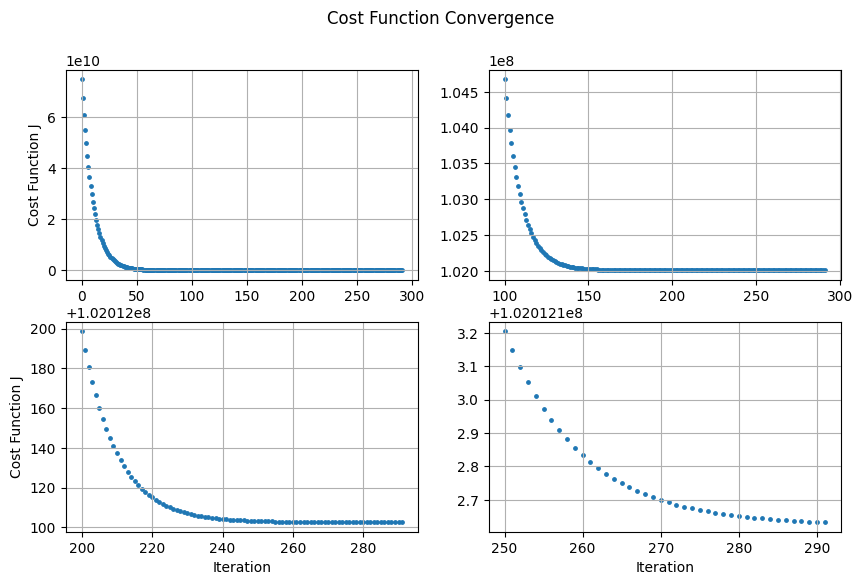

In [32]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

fig.suptitle("Cost Function Convergence")

ax[0][0].scatter(np.arange(len(w_hist1)), w_hist1, s=6)
ax[0][0].set_ylabel("Cost Function J")
ax[0][0].grid()

ax[0][1].scatter(np.arange(len(w_hist1))[100:], w_hist1[100:], s=6)
ax[0][1].grid()

ax[1][0].scatter(np.arange(len(w_hist1))[200:], w_hist1[200:], s=6)
ax[1][0].set_ylabel("Cost Function J")
ax[1][0].set_xlabel("Iteration")
ax[1][0].grid()

ax[1][1].scatter(np.arange(len(w_hist1))[250:], w_hist1[250:], s=6)
ax[1][1].set_xlabel("Iteration")
ax[1][1].grid()




The figure above shows the convergence of the cost function over the iterations with the implemented model, we can see that as is approaches the iteration 290, the difference between the cost function of previous iterations decreses significantly.

## Implementation Comparition

In [33]:
print("             sk-learn      own")
print(f"Model 1:            \n   MSE:       {mse1:.4f}     {mse_o_1:.4f}\n   Score:     {R2_1:.4f}     {R2_o1:.4f}")
print(f"Model 2:            \n   MSE:       {mse2:.4f}     {mse_o_2:.4f}\n   Score:     {R2_2:.4f}     {R2_o2:.4f}")



             sk-learn      own
Model 1:            
   MSE:       5.3828     5.4042
   Score:     0.9854     0.9853
Model 2:            
   MSE:       6.4589     6.4362
   Score:     0.9824     0.9825


We observe we get almost the same result using the basic implementation or using the SGFRegressor from sk-learn as expected, since we have a lot of data. The SGDRegressor implements SGD to increase efficiency when dealing with large datasets, at a cost of variability in the optimization process, specially when the dataset is small.

The models built with the dataset have a very good performance, with a score of approximately 0.99.

# Conclusions

Exploratory data analysis was applied succesfully, and helped to select the appropriate features to use to train the models. The two datasets used in each model showed nearly the same performance. Finally, the models built using different implementations had the same high performance.

This notebook can be improved further. Here are some ideas:

- Do feature engineering to try to improve more the models performance.
- Measure the time it takes to train each algorithm: SGDRegresor vs own implementation.
